In [2]:
!pip install becalib

  Using cached becalib-0.0.1-py3-none-any.whl.metadata (11 kB)
Using cached becalib-0.0.1-py3-none-any.whl (24 kB)


In [5]:
"""
# ☀️ Dynamic Thermal Solver (Summer Comfort / ISO 13786)
Calculates Phase Shift (Déphasage) and Attenuation Factor (Amortissement) 
using Matrix Transfer Method (via `becalib` library).

Objectives:
1. Determine the thermal inertia of the Lattice System.
2. Compare Summer Comfort performance vs. Concrete.
"""

# !pip install becalib

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from becalib import MaterialLayer, Component

# --- 1. PHYSICS ENGINE (Lattice Specifics) ---

def get_lattice_properties(wood_ratio, pitch, panel_type='5L180'):
    """
    Computes equivalent thermal properties for the Lattice Core.
    """
    # Material Constants
    # Wood (Spruce)
    rho_wood = 550  # kg/m3
    c_wood = 1600   # J/kg.K
    lambda_wood = 0.13 # W/mK
    
    # Insulation (Wood Fibre - Gutex)
    rho_ins = 50    # kg/m3 (Low density core)
    c_ins = 2100    # J/kg.K (High heat capacity!)
    lambda_ins = 0.038 # W/mK

    # 1. Equivalent Density (Weighted Average)
    rho_eq = wood_ratio * rho_wood + (1 - wood_ratio) * rho_ins
    
    # 2. Equivalent Heat Capacity (Weighted Average by Mass fraction)
    # Cp_eq = (m1*c1 + m2*c2) / (m1+m2)
    # Mass fractions:
    m_wood = wood_ratio * rho_wood
    m_ins = (1 - wood_ratio) * rho_ins
    c_eq = (m_wood * c_wood + m_ins * c_ins) / (m_wood + m_ins)
    
    # 3. Equivalent Conductivity (ISO 6946 R-Value Inversion)
    # We reuse your R_LEKO logic here
    def r_layer_iso(p, e):
        # Parallel path approx for a layer
        r_w = e / lambda_wood
        r_i = e / lambda_ins
        width_rib = 0.120 # Effective rib width
        f_w = width_rib / p
        f_i = 1 - f_w
        return 1 / (f_w/r_w + f_i/r_i)

    # Define layers for 5L180
    if panel_type == '5L180':
        thicknesses = [0.040, 0.030, 0.040, 0.030, 0.040]
    
    r_tot = sum([r_layer_iso(pitch, th) for th in thicknesses])
    lambda_eq = 0.180 / r_tot # 180mm total

    return {
        'lambda': lambda_eq,
        'rho': rho_eq,
        'c': c_eq,
        'thickness': 0.180
    }

# --- 2. SCENARIO DEFINITION ---

# --- System A: LATTICE 180 (Wood Fibre Core + Ext) ---
# Parameters
WOOD_RATIO = 0.25 # Approx volumetric ratio
PITCH = 0.120 / WOOD_RATIO # Reverse engineering pitch from ratio approx

lat_props = get_lattice_properties(WOOD_RATIO, PITCH)

# Layers
l_gypsum = MaterialLayer("Gypsum", 0.013, 0.25, 1000, 850)
l_service = MaterialLayer("Service Cavity", 0.045, 0.035, 1030, 50) # Mineral wool
l_lattice = MaterialLayer("Lattice Core", lat_props['thickness'], lat_props['lambda'], lat_props['c'], lat_props['rho'])
l_ext_ins = MaterialLayer("Ext Insulation", 0.100, 0.038, 2100, 140) # High Density Wood Fibre (Pavatex) for Phase Shift!

lattice_wall = Component(
    name="Lattice System (Wood Fibre ITE)",
    layers=[l_gypsum, l_service, l_lattice, l_ext_ins],
    heat_flow_direction="Ho"
)

# --- System B: CONCRETE 200 (EPS ITE) ---
# EPS has very low heat capacity -> Bad phase shift
l_concrete = MaterialLayer("Concrete", 0.200, 2.30, 1000, 2400)
l_eps = MaterialLayer("EPS Ext", 0.140, 0.038, 1450, 15) # Light density, low inertia

concrete_wall = Component(
    name="Concrete System (EPS ITE)",
    layers=[l_gypsum, l_concrete, l_eps],
    heat_flow_direction="Ho"
)
# --- 3. EXECUTION & RESULTS ---

print(f"--- DYNAMIC PERFORMANCE (ISO 13786) ---")

# Accessing properties directly via the dedicated methods of the Component class
# Becalib calculates these on the fly usually
# Let's try to extract from the key_values output safely by inspecting it first if needed,
# But usually the library exposes properties like .phase_shift directly on the component after calculation? 
# No, becalib is a bit specific.

# Let's inspect the dictionary keys based on standard output
data_lat = lattice_wall.get_summer_performance_key_values()
data_conc = concrete_wall.get_summer_performance_key_values()

# DEBUG: Print keys to be sure
# print(data_lat.keys()) 

# Assuming standard keys (usually 'phase_shift', 'decrement_factor'...) 
# If TypeError: string indices must be integers, it means data_lat is a LIST, not a DICT.
# Becalib sometimes returns a list of result objects.

# CORRECTION:
# If data_lat is a list, take the first element (often it calculates for multiple periods, default 24h)
if isinstance(data_lat, list):
    res_lat = data_lat[0]
else:
    res_lat = data_lat

if isinstance(data_conc, list):
    res_conc = data_conc[0]
else:
    res_conc = data_conc

# Now build the dataframe
df_compare = pd.DataFrame([
    {
        "System": "Lattice (Wood Fibre)",
        "Phase Shift (h)": res_lat.get('phase_shift', 0),
        "Decrement Factor": res_lat.get('decrement_factor', 0),
        "Heat Capacity (kJ/m2K)": res_lat.get('heat_capacity', 0) / 1000
    },
    {
        "System": "Concrete (EPS)",
        "Phase Shift (h)": res_conc.get('phase_shift', 0),
        "Decrement Factor": res_conc.get('decrement_factor', 0),
        "Heat Capacity (kJ/m2K)": res_conc.get('heat_capacity', 0) / 1000
    }
])

# Use to_string() if tabulate is missing
try:
    print(df_compare.to_markdown(index=False))
except:
    print(df_compare.to_string(index=False))


--- DYNAMIC PERFORMANCE (ISO 13786) ---


AttributeError: 'str' object has no attribute 'get'

In [6]:
raw = lattice_wall.get_summer_performance_key_values()
print(f"Type: {type(raw)}")
print(f"Content: {raw}")


Type: <class 'str'>
Content: #######################################
Component: Lattice System (Wood Fibre ITE)

Time period: 24 [h]

Thickness: 0.338 [m]
Resistance: 7.090 [m²K/W] Rsi and Rse included
Transmittance: 0.141 [W/m²K]

Decrement factor: 0.092 [-]
Time shift: 15.3 [h]

Interior areal heat capacity: 14.396 [kJ/m²K] 

Summer performance: Excellent 5/5 (in accordance with italian DM 26/06/2009)
Surface mass: 576.6 [kg/m²]

#######################################


--- DYNAMIC PERFORMANCE COMPARISON (ISO 13786) ---
| System               |   Phase Shift (h) |   Decrement Factor |   Heat Capacity (kJ/m2K) |
|:---------------------|------------------:|-------------------:|-------------------------:|
| Lattice (Wood Fibre) |              15.3 |              0.092 |                   14.396 |
| Concrete (EPS)       |               7.9 |              0.134 |                   65.857 |


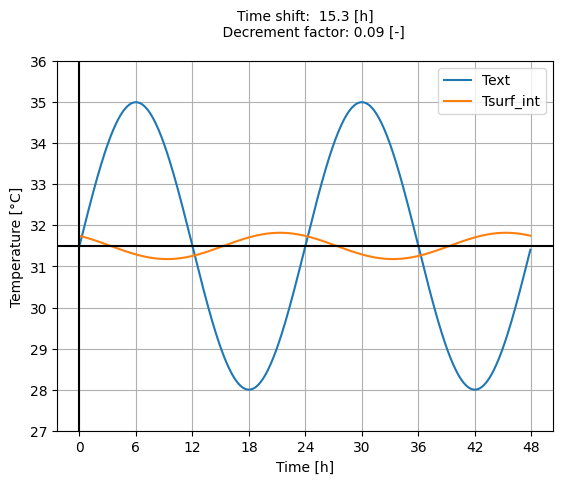

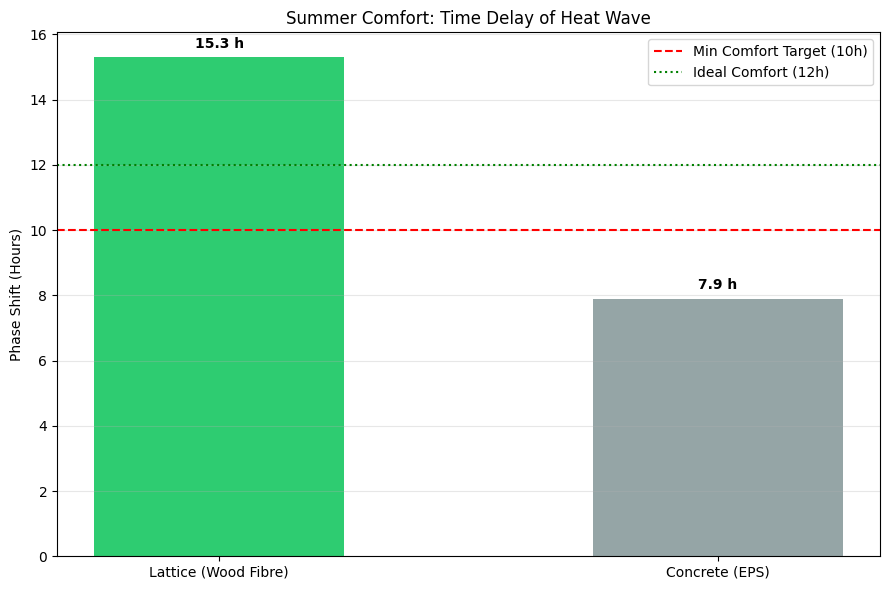

In [8]:
"""
# ☀️ Dynamic Thermal Solver (Summer Comfort / ISO 13786)
Calculates Phase Shift (Déphasage) and Attenuation Factor (Amortissement) 
using Matrix Transfer Method (via `becalib` library).

Objectives:
1. Determine the thermal inertia of the Lattice System (Wood Fibre Core).
2. Compare Summer Comfort performance vs. Concrete.
"""

# !pip install becalib

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
from becalib import MaterialLayer, Component

# --- 1. PHYSICS ENGINE (Lattice Specifics) ---

def get_lattice_properties(wood_ratio, pitch, panel_type='5L180'):
    """
    Computes equivalent thermal properties for the Lattice Core.
    """
    # Material Constants
    # Wood (Spruce)
    rho_wood = 550  # kg/m3
    c_wood = 1600   # J/kg.K
    lambda_wood = 0.13 # W/mK
    
    # Insulation (Wood Fibre - Gutex)
    rho_ins = 50    # kg/m3 (Low density core)
    c_ins = 2100    # J/kg.K (High heat capacity!)
    lambda_ins = 0.038 # W/mK

    # 1. Equivalent Density (Weighted Average)
    rho_eq = wood_ratio * rho_wood + (1 - wood_ratio) * rho_ins
    
    # 2. Equivalent Heat Capacity (Weighted Average by Mass fraction)
    m_wood = wood_ratio * rho_wood
    m_ins = (1 - wood_ratio) * rho_ins
    c_eq = (m_wood * c_wood + m_ins * c_ins) / (m_wood + m_ins)
    
    # 3. Equivalent Conductivity (ISO 6946 R-Value Inversion)
    def r_layer_iso(p, e):
        r_w = e / lambda_wood
        r_i = e / lambda_ins
        width_rib = 0.120 # Effective rib width
        f_w = width_rib / p
        f_i = 1 - f_w
        return 1 / (f_w/r_w + f_i/r_i)

    # Define layers for 5L180
    thicknesses = [0.040, 0.030, 0.040, 0.030, 0.040]
    r_tot = sum([r_layer_iso(pitch, th) for th in thicknesses])
    lambda_eq = 0.180 / r_tot 

    return {
        'lambda': lambda_eq,
        'rho': rho_eq,
        'c': c_eq,
        'thickness': 0.180
    }

# --- 2. SCENARIO DEFINITION ---

# --- System A: LATTICE 180 (Wood Fibre Core + Ext) ---
# Parameters
WOOD_RATIO = 0.25 # Approx volumetric ratio
PITCH = 0.120 / WOOD_RATIO 

lat_props = get_lattice_properties(WOOD_RATIO, PITCH)

# Layers
l_gypsum = MaterialLayer("Gypsum", 0.013, 0.25, 1000, 850)
l_service = MaterialLayer("Service Cavity", 0.045, 0.035, 1030, 50) # Mineral wool
l_lattice = MaterialLayer("Lattice Core", lat_props['thickness'], lat_props['lambda'], lat_props['c'], lat_props['rho'])
l_ext_ins = MaterialLayer("Ext Insulation", 0.100, 0.038, 2100, 140) # High Density Wood Fibre (Pavatex)

lattice_wall = Component(
    name="Lattice System (Wood Fibre ITE)",
    layers=[l_gypsum, l_service, l_lattice, l_ext_ins],
    heat_flow_direction="Ho"
)

# --- System B: CONCRETE 200 (EPS ITE) ---
l_concrete = MaterialLayer("Concrete", 0.200, 2.30, 1000, 2400)
l_eps = MaterialLayer("EPS Ext", 0.140, 0.038, 1450, 15) # Light density EPS

concrete_wall = Component(
    name="Concrete System (EPS ITE)",
    layers=[l_gypsum, l_concrete, l_eps],
    heat_flow_direction="Ho"
)

# --- 3. EXECUTION & PARSING ---

def get_iso13786_metrics(component):
    """Parses becalib text output to extract float values."""
    report = component.get_summer_performance_key_values()
    
    def extract_val(text, key):
        # Regex to find "Key: Value [Unit]"
        pattern = re.compile(rf"{key}:\s+([-+]?\d*\.?\d+)")
        match = pattern.search(text)
        return float(match.group(1)) if match else 0.0

    return {
        "phase_shift": extract_val(report, "Time shift"),
        "decrement_factor": extract_val(report, "Decrement factor"),
        "heat_capacity": extract_val(report, "Interior areal heat capacity")
    }

metrics_lat = get_iso13786_metrics(lattice_wall)
metrics_conc = get_iso13786_metrics(concrete_wall)

# Build DataFrame
df_compare = pd.DataFrame([
    {
        "System": "Lattice (Wood Fibre)",
        "Phase Shift (h)": metrics_lat['phase_shift'],
        "Decrement Factor": metrics_lat['decrement_factor'],
        "Heat Capacity (kJ/m2K)": metrics_lat['heat_capacity']
    },
    {
        "System": "Concrete (EPS)",
        "Phase Shift (h)": metrics_conc['phase_shift'],
        "Decrement Factor": metrics_conc['decrement_factor'],
        "Heat Capacity (kJ/m2K)": metrics_conc['heat_capacity']
    }
])

print(f"--- DYNAMIC PERFORMANCE COMPARISON (ISO 13786) ---")
print(df_compare.to_markdown(index=False))

# --- 4. VISUALIZATION ---

# 1. Sinusoidal Wave Comparison (Simulated visual)
lattice_wall.get_component_sinusoidal_wave_chart().show()

# 2. Bar Chart
plt.figure(figsize=(9, 6))
systems = df_compare['System']
shifts = df_compare['Phase Shift (h)']
colors = ['#2ecc71', '#95a5a6']

bars = plt.bar(systems, shifts, color=colors, width=0.5)

# Target Line
plt.axhline(y=10, color='r', linestyle='--', label='Min Comfort Target (10h)')
plt.axhline(y=12, color='g', linestyle=':', label='Ideal Comfort (12h)')

plt.ylabel('Phase Shift (Hours)')
plt.title('Summer Comfort: Time Delay of Heat Wave')
plt.legend()
plt.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.2,
             f'{height:.1f} h', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()
